<img src="./pictures/logo-insa.png" style="float:right; max-width: 60px; display: inline" alt="INSA" />

# Radiator
 
*Written by Marc Budinger, INSA Toulouse, France*

The radiator allows heat to be evacuated to the air outside the vehicle. A sufficient flow must be ensured in order to obtain an interesting transfer efficiency. The following figures taken from [[Tojcic2017](#References)] represent the air flow and the pressure trace in the compartment under the hood of the vehicle. Pressure drops must be compensated by the static pressure from vehicle speed or by the fan.

*Illustration of airflow and pressure trace in vehicle underhood compartment*  
<img src="07/PressureDropUnderHood.png" width="600">

We will base and validate our calculations and models on an industrial [range](https://www.boydcorpdirect.com/store/heat-exchangers/) of liquid to air heat exchangers (copper tube-fin heat exchanger). These cross flow heat exchangers delivers efficient heat transfer with copper tubing expanded into copper cooling fins.

*Copper Tube-Fin Liquid-to-Air Heat Exchanger*  
<img src="07/CopperTubeHeatEchangerBoyd.png" width="300">


## 1. Radiator efficiency estimation thanks NTU method

The [Number of Transfer Units (NTU) Method](https://en.wikipedia.org/wiki/NTU_method) is used to calculate the rate of heat transfer in heat exchangers with a reduced amount of information:
- the heat exchange flow: $\dot{Q}=\dot{m_h}c_h(T_{h,i}-T_{h,o})=\dot{m_c}c_c(T_{c,o}-T_{c,i})$
with mass flow $\dot{m}$, specific heat capacity $c$, the temperatures at the inlet and outlet of the exchanger $T$. Indices $c$ and $f$ refer to hot and cold fluids.  

- the efficiency: $\epsilon=\frac{\dot{Q}}{\dot{Q}_{max}}$ 
with $\dot{Q}_{max}$ the maximum exchangeable power in an ideal case
$\dot{Q}_{max}=min(\dot{m_h}c_h)(T_{h,i}-T_{c,i})$

#### 1.1. $UA$ parameter and efficiency

For a given geometry, the efficiency $\epsilon$ can be calculated using correlations in terms of  "heat capacity ratio" $C_r= \frac{C_{min}}{C_{max}} $
and the number of transfer units $NTU=\frac{UA}{C_{min}}$ (both dimensionless numbers) where   $U$ is the overall heat transfer coefficient and $A$ is the heat transfer area. For cross-flow heat exchangers with both fluids unmixed this relation is:  
$\epsilon=1-e^{\frac{NTU^{0.22} (e^{-C_r NTU^{0.78}}-1)}{C_r}}$ 

> **Question:** Explain how to evaluate efficiency of this heat exchanger from the following curve. Give a numerical application for an airflow of $1.5m^3/min$ and a waterflow of $1.8 l/min$. Propose a way to estimate the $UA$ parameter of the heat exchanger.

*Boyd component [information](https://www.boydcorpdirect.com/6110g1-copper-tube-fin-heat-exchanger/6110g1/)*  
<img src="https://www.boydcorpdirect.com/assets/1/6/DimLarge/Heat-Exchanger-6110-Metric-Graph1.jpg?880" width="500">



**Answers:**

$\epsilon=\frac{\dot{Q}}{\dot{Q}_{max}}=\frac{\dot{Q}}{T_{h,i}-T_{c,i}} \frac{1}{min(\dot{m_h}c_h)}=\frac{\dot{Q}}{T_{h,i}-T_{c,i}} \frac{1}{\dot{m}_{air}c_{air}}$   
The efficiency is thus the ratio of coordinates of the given figure.


In [3]:
# Flows
Flow_air=1.5/60 # [m^3/s] 
Flow_water=1.8e-3/60 # [m^3/s] 
 
# Specific heat capacity 
C_air=1003.5 # [J⋅kg−1⋅K−1] specific heat capacity cP of air
C_water=4185 # [J⋅kg−1⋅K−1] specific heat capacity cP of water 

# Density
Rho_water=998 # [kg/m^3 water density]
Rho_air=1.18 # [kg/m^3] air density 25°C 

# Mass Flow and heat flow
MassFlow_air=Rho_air*Flow_air # [kg/s]
MassFlow_water=Rho_water*Flow_water # [kg/s]

HeatFlow_air=C_air*MassFlow_air # [J/s]
HeatFlow_water=C_water*MassFlow_water # [J/s]

# Heat flow per degree
Q_DT=16 # [W/K]

# Water side
Eps=Q_DT/HeatFlow_air

print("Heat sink efficiency: %.2f %%"%(Eps*100))

Heat sink efficiency: 54.05 %


#### 1.2. $UA$ estimation

To estimate the $UA$ coefficient of this heat exchanger, will use the complete diagram and adjust thanks optimization this coefficient in order to fit the curve. First a dataframe is defined in order to store the usefull data.

In [4]:
import pandas as pd
import numpy as np

df=pd.DataFrame({'AirFlow': np.array([0.5,1,1.5,2,2.5])*1/60, 'Q/dT':[8,13,16,18.5,20.5]})

df['Cmin']=df.AirFlow*C_air*Rho_air

df['Efficiency']=df['Q/dT']/df['Cmin']

df['Cmax']=HeatFlow_water
df['Cr']=df['Cmin']/df['Cmax']

df

,AirFlow,Q/dT,Cmin,Efficiency,Cmax,Cr
0,0.008333,8.0,9.86775,0.810722,125.2989,0.078754
1,0.016667,13.0,19.73550,0.658711,125.2989,0.157507
2,0.025000,16.0,29.60325,0.540481,125.2989,0.236261
3,0.033333,18.5,39.47100,0.468699,125.2989,0.315015
4,0.041667,20.5,49.33875,0.415495,125.2989,0.393768


A function is then created in order to minimize error and fit at best the curve.

In [5]:
# Efficiency function for cross flow heat exchangers
def efficiency(UA, Cmin, Cr):
    NTU=UA/Cmin
    return 1-np.exp(NTU**0.22*(np.exp(-Cr*NTU**0.78)-1)/Cr)

# Error between function and industrial data
def SumError(UA):
    Error2 = (efficiency(UA, df['Cmin'], df['Cr']) - df['Efficiency'])**2
    return np.sum(Error2)                         

from scipy.optimize import minimize_scalar
res = minimize_scalar(SumError)
UA=res.x

print("Best UA coefficient: %.1f W/K"%UA)

Best UA coefficient: 24.9 W/K


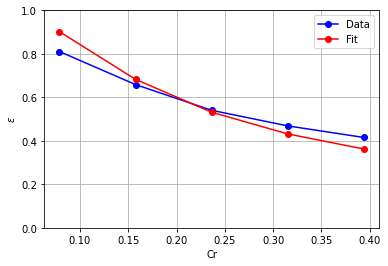

,AirFlow,Q/dT,Cmin,Efficiency,Cmax,Cr,NTU,EffiFit
0,0.008333,8.0,9.86775,0.810722,125.2989,0.078754,2.519068,0.902288
1,0.016667,13.0,19.73550,0.658711,125.2989,0.157507,1.259534,0.682700
2,0.025000,16.0,29.60325,0.540481,125.2989,0.236261,0.839689,0.531766
3,0.033333,18.5,39.47100,0.468699,125.2989,0.315015,0.629767,0.431871
4,0.041667,20.5,49.33875,0.415495,125.2989,0.393768,0.503814,0.362324


In [6]:
import matplotlib.pyplot as plt 

df['NTU']=UA/df['Cmin']
df['EffiFit']=efficiency(UA, df['Cmin'], df['Cr'])

#Plot Reynolds number 
plt.plot(df['Cr'], df['Efficiency'], 'o-b', label='Data')
plt.plot(df['Cr'], df['EffiFit'], 'o-r', label='Fit')
plt.xlabel('Cr')
plt.ylabel('$\epsilon$')
plt.ylim(0, 1)
plt.grid()
plt.legend()
plt.show()

df

## 2. UA coefficient regression

The process of obtaining the UA coefficient was carried out on a whole range of exchangers. These data will make it possible to obtain an estimation function of this parameter as a function of the main dimensions of the exchanger.

In [7]:
# Import Heat Exchanger data

dHE = pd.read_excel('./07/BoydCopperTubeHE.xlsx')

# Print the head (first lines of the file)
dHE.head()

,Power[W],UA[W/K],L[m],W[m],H[m],Mass[kg],Air DP/Q^2 [Pa/(m^3/s)²],Water DP/Q^2 [Pa/(m^3/s)²],Liquid volume[l]
0,360,13.100,0.188,0.033,0.168,1.18,11250.000000,6.232687e+11,0.050
1,430,24.420,0.188,0.048,0.147,1.15,30000.000000,2.077562e+12,0.131
2,700,48.770,0.310,0.046,0.147,2.31,11250.000000,2.493075e+12,0.205
3,1230,69.917,0.301,0.064,0.229,2.99,4591.836735,3.739612e+12,0.288
4,2000,132.465,0.505,0.064,0.229,4.99,1434.948980,6.232687e+12,0.500


> **Question**:  Set up the regression of these data on a power law of the form $UA=kL^aW^bH^c$.

In [8]:
# Determination of the least squares estimator with LinearRegression of sklearn

from sklearn import linear_model

# Generation of Y and X matrix
YHE=np.log10(dHE['UA[W/K]'].values)
YHE=YHE.reshape((np.size(YHE),1))
XHE=np.transpose((np.log10(dHE['L[m]'].values), np.log10(dHE['W[m]'].values), np.log10(dHE['H[m]'].values) ))


# OLS regression
reg= linear_model.LinearRegression()
reg.fit(XHE, YHE)

# Results print
print("R² coefficient : %.2f"%reg.score(XHE, YHE))

coef=reg.coef_.reshape(3)
print('The estimation function is: UA = %.3g.L^%.2f.W^%3.2f.H^%3.2f'
      %(10**reg.intercept_,coef[0],coef[1],coef[2]))
print('with UA in [W/K], W, H, L in [m]')

R² coefficient : 0.98
The estimation function is: UA = 1.51e+04.L^1.41.W^1.05.H^0.51
with UA in [W/K], W, H, L in [m]


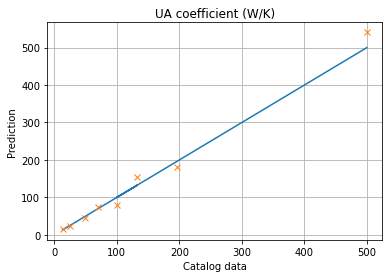

In [9]:
# Y vector prediction

y_HE=10**(reg.predict(XHE))

# plot the data 
#plt.plot(dHS['Rthn'].values,dHS['Rthn'].values, '-',dHS['Rthn'].values,y_HS, 'o')
plt.plot(dHE['UA[W/K]'].values,dHE['UA[W/K]'].values, '-')
plt.plot(dHE['UA[W/K]'].values,y_HE, 'x')
plt.xlabel('Catalog data')
plt.ylabel('Prediction')
plt.title('UA coefficient (W/K)')
plt.grid()
plt.show()

## 3. Pressure drop

The selection of motors and pumps requires knowing the flow rate, depending on the flow of trawl to be transferred, and the pressure drops.

### 3.1. Air side

On the air side, the pressure drops are located at several levels:
- at the level of the exchanger, they are characterized by a flow / pressure curve provided by the manufacturer

*Air side pressure drop*  
<img src="07/AirSidePressureDrop.png" width="400">

- at the level of the air inlets and exhaust under the hood of the vehicle. These losses can be considered as [minor](https://www.engineeringtoolbox.com/air-duct-minor-loss-diagram-d_332.html) and can be expressed thanks coefficients depending of geometrical configurations. 

$Δp_{minor loss} = ξ p_d =  ξ \frac{1}{2} ρ_f v^2$                                      

where

$ξ$ = minor loss coefficient

$p_d$ = dynamic pressure in fluid flow (Pa)

$Δp_{minor loss}$ = minor pressure loss (Pa)

$ρ_f$ = density of fluid (kg/m3)

$v$ = flow velocity (m/s)

> **Question:** Propose, depending on the flow rate to be ensured and the geometry of the exchanger, the expression of the overall pressure drop to be compensated.


**Answer :** On suppose l'ensemble des chutes de pression fonction quadratique du débit ou de la vitesse. 
Pour les pertes singulière on peut supposer une coefficient global ξ d'environ 4 avec 1.5 pour l'entrée et la sortie d'air et 1 pour un coude à 90°.   
Pour les pertes de charges du dissipateur une regression des données catalogues permet d'obtenir une expression de la forme: 
$\frac{Δp}{Q^2}=10^{3.29}L^{-2.34}W^{1.67}H^{-1.98}$ 

### 3.2. Water side

On the water side, different fluid flow patterns can be observed with very different pressure drop levels.

*2 different tube configurations*  
<img src="07/TubeConfig.png" width="600">

> **Question:** Propose a design hypothesis to simplify the calculations for the preliminary sizing.


**Answer :** On voit que la configuration de type "parallèle" réduit de manière significative les chutes de pression. On supposera pour la suite que nous sommes dans cete configuration et que la chute de pression dans l'échanguer sera négligeable par rapport à celle du reste du circuit liquide (plaque froide et réseau de tubes). 

## 4. Heat exchanger mass and liquid volume

The exchanger masses and the fluid volume present in the exchanger will be useful for optimizing the overall system and for setting up transient simulations.

> **Question:** Use excel file data to set up estimaation laws for mass of exchanger and volume of liquid. [Correlation analysis](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html) and [graphical matrix](https://datatofish.com/correlation-matrix-pandas/) representation can be usefull in order to select the most influencing inputs.



**Answer:** L'analyse de correlation réalisée ici sous excel permet d'envisager de relier la masse et le volume au coefficient UA. Par regression on obtient

$Volume=0.0052(UA)^{0.9512}$ avec le volume en l  
$Mass = 0.12(UA)^{0.793}$ avec la masse en kg

In [10]:
# log transformation of the data
dHElog=pd.DataFrame(data=np.log10(dHE.values), columns=dHE.columns)

dHElog.corr()

,Power[W],UA[W/K],L[m],W[m],H[m],Mass[kg],Air DP/Q^2 [Pa/(m^3/s)²],Water DP/Q^2 [Pa/(m^3/s)²],Liquid volume[l]
Power[W],1.000000,0.986381,0.941340,0.848500,0.945061,0.990271,-0.953673,-0.480353,0.975993
UA[W/K],0.986381,1.000000,0.962802,0.878215,0.887230,0.969605,-0.920513,-0.403554,0.993063
L[m],0.941340,0.962802,1.000000,0.772193,0.811614,0.930170,-0.938896,-0.328671,0.938087
W[m],0.848500,0.878215,0.772193,1.000000,0.770733,0.782452,-0.684143,-0.321649,0.871874
H[m],0.945061,0.887230,0.811614,0.770733,1.000000,0.934628,-0.910702,-0.685718,0.870224
Mass[kg],0.990271,0.969605,0.930170,0.782452,0.934628,1.000000,-0.958191,-0.480861,0.962425
Air DP/Q^2 [Pa/(m^3/s)²],-0.953673,-0.920513,-0.938896,-0.684143,-0.910702,-0.958191,1.000000,0.441339,-0.897433
Water DP/Q^2 [Pa/(m^3/s)²],-0.480353,-0.403554,-0.328671,-0.321649,-0.685718,-0.480861,0.441339,1.000000,-0.372002
Liquid volume[l],0.975993,0.993063,0.938087,0.871874,0.870224,0.962425,-0.897433,-0.372002,1.000000


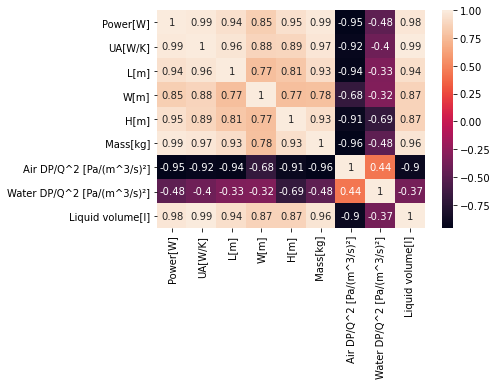

In [11]:
# Correlation matrix
import seaborn as sn

dHE= pd.read_excel('./07/BoydCopperTubeHE.xlsx')

dHE = np.log10(dHE)
Matrice = dHE.corr()

sn.heatmap(Matrice, annot = True)

plt.show()

## References

> - Tojcic, S. (2017). *Effects of Heat Transfer on Vehicle Front-end Cooling Airflow Simulation*, Master of Applied Science Thesis, University of Windsor. [Link](https://scholar.uwindsor.ca/cgi/viewcontent.cgi?article=6956&context=etd)  
> - Kim, H. J., & Kim, C. (2008). *A numerical analysis for the cooling module related to automobile air-conditioning system. Applied Thermal Engineering*, 28(14-15), 1896-1905. [DOI](doi:10.1016/j.applthermaleng.2007.12.002)
> - Lu, P., Gao, Q., & Wang, Y. (2016). *The simulation methods based on 1D/3D collaborative computing for the vehicle integrated thermal management*. Applied Thermal Engineering,104, 42-53. [DOI](doi:10.1016/j.applthermaleng.2016.05.047)
> - Budinger, M., Hazyuk, I., & Coïc, C. (2019). *Multi-physics Modeling of Technological Systems*. ISTE Limited.